<br><p style="font-family: Arial; font-size:2.5em;color:purple; font-style:bold">
t-SNE Visualization <br><br> <u>t-SNE visualization of Amazon reviews with polarity based</u> <br><br> <u>color-coding</u></p><br><br>

# Amazon Fine Food Reviews
* t-SNE visualization of Amazon fine food reviews(positive and negative) with polarity based color-coding
* The dataset can be found on the page: https://www.kaggle.com/snap/amazon-fine-food-reviews/data

## About the data set:
* Id: Review Id
* ProductId: Unique identifier for the product
* UserId: Unqiue identifier for the user
* ProfileName: Profile name of the user
* HelpfulnessNumerator: Number of users who found the review helpful
* HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not
* Score: Rating between 1 and 5
* Time: Timestamp for the review
* Summary: Brief summary of the review
* Text: Text of the review

## Overall Objective:
* Classify both positive and negative reviews using t-SNE visualization

In [1]:
# Import necessary modules for the purpose

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import time

C:\Users\soura\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [34]:
# Load the fine food reviews data from the csv file and load it to a dataframe
review_data = pd.read_csv("Reviews.csv")
review_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [35]:
# check for the review data informations
print("\n***************************** Data Informations *****************************\n\n")
print(review_data.info())
print("\n***************************** Shape of datafile ******************************\n")
print("Total reviews: {}".format(review_data.shape[0]))
print("Total features: {}".format(review_data.shape[1]))


***************************** Data Informations *****************************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None

***************************** Shape of datafile ******************************

Total reviews: 568454
Total features: 10


### Filtering only those reviews which are only positive & negative (not the neutral one)
* If `Score` is greate than `3` then the review is `POSITIVE`
* If `Score` is less than `3` then the review is `Negative`

In [36]:
review_data = review_data.loc[review_data['Score'] != 3]
review_data['ReviewType'] = review_data['Score'].map(lambda x: 'POSITIVE' if x > 3 else 'NEGATIVE')
review_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewType
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,POSITIVE
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,POSITIVE
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,POSITIVE


### Data Cleaning process
* Like `deduplication`

In [37]:
# Sorting the data for the purpose of ease
processed_review = review_data.sort_values(by='ProductId')
processed_review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewType
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,POSITIVE
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",POSITIVE
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,POSITIVE
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,5,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,POSITIVE
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,5,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,POSITIVE


In [38]:
# Removing duplicate rows
processed_review.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)
processed_review.shape

(364173, 11)

In [39]:
# Removing the data where `HelpfullnessNumarator` is greate than `HelpfullnessDenominator`
processed_review = processed_review[processed_review['HelpfulnessNumerator'] <= processed_review['HelpfulnessDenominator']]
processed_review.shape

(364171, 11)

### Observations:
* The original data has 568454 reviews
* After cleaning we have only 364171 reviews
* Significant number of reviews has been filtered out while deduplication

## Text Preprosessing
* Removing HTML tags nd texts
* Remove puncuations and special charaters

In [40]:
processed_review.iloc[6]['Text']

"I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best."

In [41]:
# Removing HTML tags
html_compiler = re.compile('<.*?>')
processed_review['Text'] = processed_review['Text'].map(lambda x:re.sub(html_compiler, ' ', x))
processed_review.iloc[6]['Text']

"I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.  First, this book taught him the months of the year.  Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.  Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best."

In [42]:
# Removing punctuations and special characters
punc_spl_compiler=re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/]')
processed_review['Text'] = processed_review['Text'].map(lambda x:re.sub(punc_spl_compiler, '', x))
processed_review.iloc[6]['Text']

'I set aside at least an hour each day to read to my son 3 yo At this point I consider myself a connoisseur of childrens books and this is one of the best Santa Clause put this under the tree Since then weve read it perpetually and he loves it  First this book taught him the months of the year  Second its a pleasure to read Well suited to 15 yo old to 4+  Very few childrens books are worth owning Most should be borrowed from the library This book however deserves a permanent spot on your shelf Sendaks best'

In [43]:
#check for the positive datas and negative datas
processed_review_positive = processed_review[processed_review['ReviewType'] == 'POSITIVE']
processed_review_negative = processed_review[processed_review['ReviewType'] == 'NEGATIVE']
print(processed_review.shape)
print(processed_review_positive.shape)
print(processed_review_negative.shape)

(364171, 11)
(307061, 11)
(57110, 11)


## Pickle all cleaned data
* This pickeled clean data can be used for further processing

In [44]:
# Pickling the cleaned data frame for future use
processed_review.to_pickle("all_cleaned_review.pkl")

## Get sample datas for further processing

In [34]:
# get sample data
processed_review_positive = processed_review_positive[0:5000]
processed_review_negative = processed_review_negative[0:5000]
print(processed_review_positive.shape)
print(processed_review_negative.shape)

(5000, 11)
(5000, 11)


In [35]:
# Concat dataframes
processed_review = pd.concat([processed_review_positive, processed_review_negative])
processed_review.shape

(10000, 11)

### Pickle sample cleaned data to file

In [36]:
# Pickling the cleaned data frame for future use
processed_review.to_pickle("cleaned_10k_review.pkl")

## Text to Vector conversion
## 1. Bag of Word (BoW)

In [14]:
# text to vector conversion using BoW
bow = CountVectorizer()
bow_counts = bow.fit_transform(processed_review['Text'])
bow_counts.get_shape()

(10000, 25611)

In [15]:
# Converting to numpy array array
bow_counts = bow_counts.toarray()
bow_counts[0:2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
# Coverting the vector to the dataframe
bow_vector_dataframe = pd.DataFrame(bow_counts)
del bow_counts
bow_vector_dataframe.shape

(10000, 25611)

In [17]:
# reset index for the processed data before merge 
processed_review.reset_index(inplace=True)
final_boa_data = pd.concat([processed_review, bow_vector_dataframe], axis=1)
final_boa_data.shape

(10000, 25623)

In [18]:
# removing the unnecessary columns
final_boa_data.drop(['index','Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time', 'Summary', 'Text'], axis=1, inplace=True)
final_boa_data.shape

(10000, 25612)

In [20]:
final_boa_data.head()

,ReviewType,0,1,2,3,4,5,6,7,8,...,25601,25602,25603,25604,25605,25606,25607,25608,25609,25610
0,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.1 Pickling the BoW data for further use

In [22]:
# Pickling the processed data frame for future use
final_boa_data.to_pickle("bow_10k_positive_negative_reviews.pkl")

In [ ]:
# Deleting the old dataframe and retriving it from the pickled file
del final_boa_data

In [18]:
final_bow_data = pd.read_pickle("bow_10k_positive_negative_reviews.pkl")
final_bow_data.head()

,ReviewType,0,1,2,3,4,5,6,7,8,...,25601,25602,25603,25604,25605,25606,25607,25608,25609,25610
0,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,POSITIVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###  1.2 T-SNE Plot

In [19]:
# Seperate the lable and the data
bow_label = final_bow_data['ReviewType']
bow_data = final_bow_data.drop('ReviewType', axis=1)
del final_bow_data
print(bow_label[0:5])
print(bow_data.head())

0    POSITIVE
1    POSITIVE
2    POSITIVE
3    POSITIVE
4    POSITIVE
Name: ReviewType, dtype: object
   0      1      2      3      4      5      6      7      8      9      \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   ...    25601  25602  25603  25604  25605  25606  25607  25608  25609  25610  
0  ...        0      0      0      0      0      0      0      0      0      0  
1  ...        0      0      0      0      0      0      0      0      0      0  
2  ...        0      0      0      0      0      0      0      0      0      0  
3  ...        0      0      0      0      0      0      0      0      0      0  
4  ...        0      0      0      0      

In [20]:
# Standardize the data
standard_bow_data = StandardScaler().fit_transform(bow_data)
del bow_data
standard_bow_data.shape

(10000, 25611)

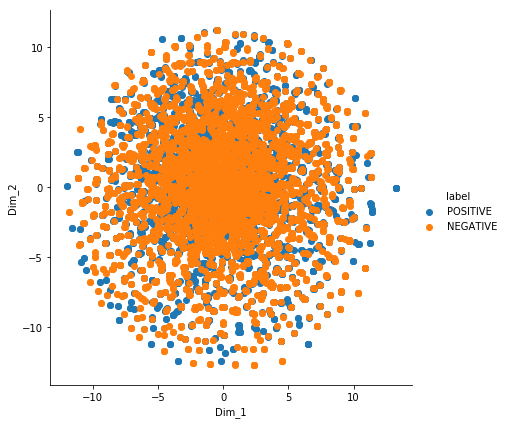

Total time taken:  912.446763753891


In [6]:
# Applying t-SNE algorithm and plotting data
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0)

tsne_data = model.fit_transform(standard_bow_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, bow_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

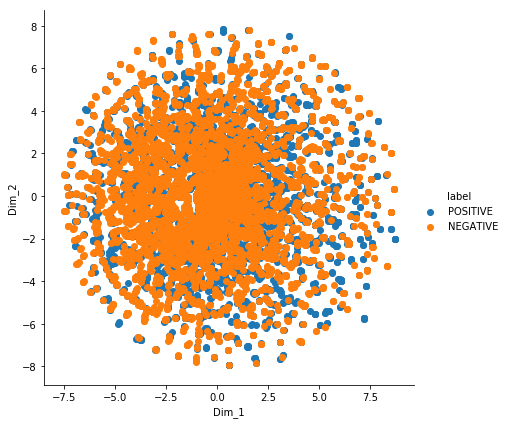

Total time taken:  1135.0219814777374


In [16]:
# Applying t-SNE algorithm and plotting data for 50.0 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, perplexity=50.0)

tsne_data = model.fit_transform(standard_bow_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, bow_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

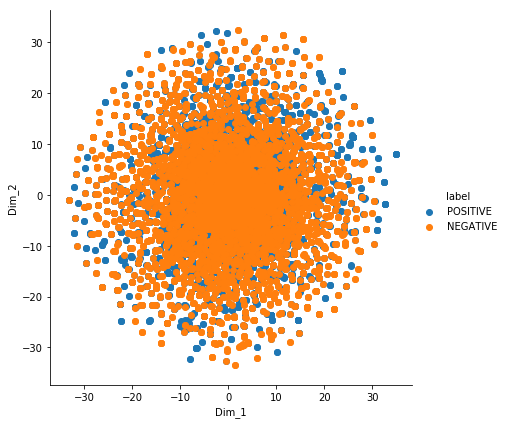

Total time taken:  866.1019310951233


In [21]:
# Applying t-SNE algorithm and plotting data for 10.0 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, perplexity=10.0)

tsne_data = model.fit_transform(standard_bow_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, bow_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

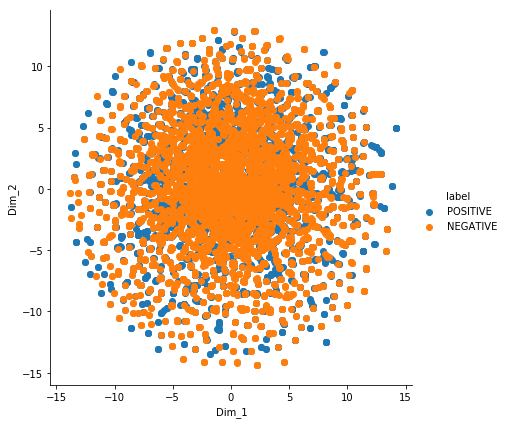

Total time taken:  1033.0176379680634


In [22]:
# Applying t-SNE algorithm and plotting data for 5000 iteration
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000)

tsne_data = model.fit_transform(standard_bow_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, bow_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

## 2. TFIDF technique to convert Text to Vector

In [11]:
# Getting the cleaned data (taking 4k positive and negative data so that memory error should not occur)
preprossed_data = pd.read_pickle("cleaned_10k_review.pkl")
preprossed_data_positive = preprossed_data[preprossed_data['ReviewType'] == 'POSITIVE'].head(1000)
preprossed_data_negative = preprossed_data[preprossed_data['ReviewType'] == 'NEGATIVE'].head(1000)
preprossed_data = pd.concat([preprossed_data_positive, preprossed_data_negative])
preprossed_data.shape

(2000, 11)

In [12]:
# Applying tfidf technique
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(preprossed_data['Text'])
final_tf_idf.shape

(2000, 98011)

In [13]:
# Converting to numpy array
processed_data_final = final_tf_idf.toarray()
processed_data_final[0:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Standardize the data
standard_tfidf_data = StandardScaler().fit_transform(processed_data_final)
# del tfidf_data
standard_tfidf_data.shape

(2000, 98011)

In [15]:
tfidf_label = preprossed_data['ReviewType']
len(tfidf_label)

2000

### 2.1 Applying TSNE

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


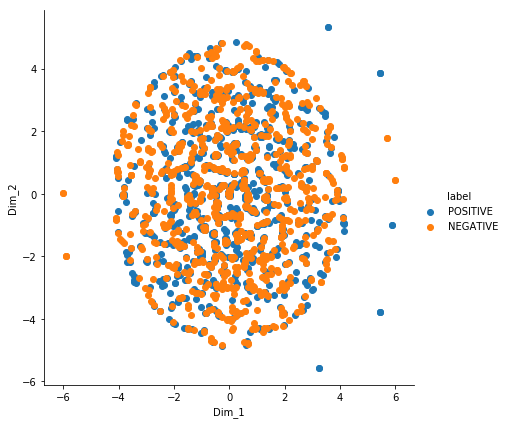

Total time taken:  225.44594264030457


In [16]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 10 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=10.0)

tsne_data = model.fit_transform(standard_tfidf_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, tfidf_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


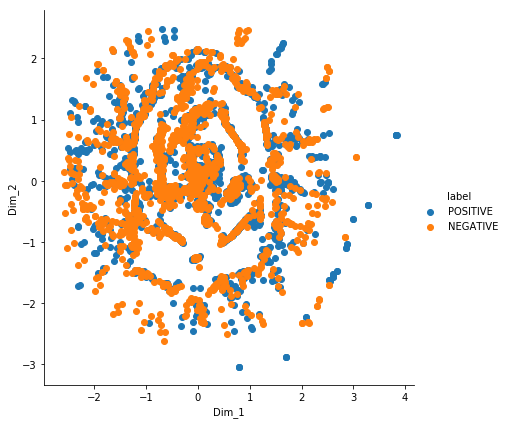

Total time taken:  153.79596853256226


In [9]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 30 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=30.0)

tsne_data = model.fit_transform(standard_tfidf_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, tfidf_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


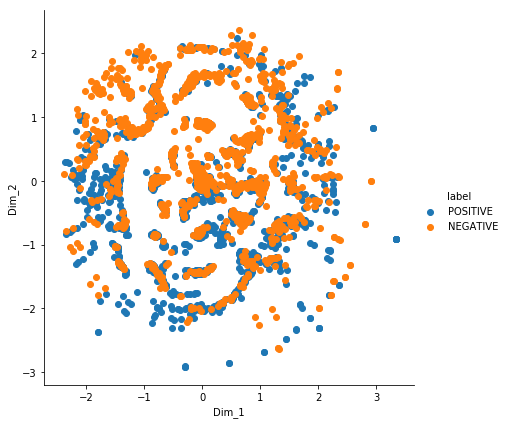

Total time taken:  211.1307020187378


In [10]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 50 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=50.0)

tsne_data = model.fit_transform(standard_tfidf_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, tfidf_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

## 3. Word to Vector (W2V) technique

In [13]:
# Getting the cleaned data (taking 5k positive and negative data so that memory error should not occur)
preprossed_data = pd.read_pickle("all_cleaned_review.pkl")
preprossed_data_positive = preprossed_data[preprossed_data['ReviewType'] == 'POSITIVE'].head(5000)
preprossed_data_negative = preprossed_data[preprossed_data['ReviewType'] == 'NEGATIVE'].head(5000)
preprossed_data = pd.concat([preprossed_data_positive, preprossed_data_negative])
preprossed_data.shape

(10000, 11)

In [14]:
# Training W2V for my featured data (Amazon fine food reviews)
all_sentences = [sentence.split() for sentence in preprossed_data['Text']]
print(len(all_sentences))
print(all_sentences[0])

10000
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'India', 'drooping', 'roses:', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'STILL', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [5]:
# Applying to W2V model
w2v_model=Word2Vec(all_sentences,min_count=5,size=50, workers=4) # min count --> ignore those words having count less than 5, size --> dimensions for each word

In [6]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8498
sample words  ['this', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'hes', 'learned', 'about', 'India', 'love', 'all', 'new', 'words', 'of', 'is', 'a', 'classic', 'am', 'willing', 'to', 'bet', 'will', 'STILL', 'be', 'able', 'from', 'memory', 'when', 'college', 'I', 'grew', 'up']


In [64]:
# getting most similar words for a particular word
w2v_model.wv.most_similar('fine')

[('terrible', 0.8491460084915161),
 ('okay', 0.8442062139511108),
 ('delicious', 0.8293386101722717),
 ('awful', 0.8244993686676025),
 ('perfect', 0.8159014582633972),
 ('fantastic', 0.8136920928955078),
 ('horrible', 0.81092768907547),
 ('beautiful', 0.8099843263626099),
 ('ok', 0.8054923415184021),
 ('wonderful', 0.803043007850647)]

In [65]:
w2v_model.wv.most_similar('nice')

[('strong', 0.844955325126648),
 ('wonderful', 0.8399003744125366),
 ('light', 0.8382802605628967),
 ('thick', 0.8340247869491577),
 ('weak', 0.8290379047393799),
 ('perfect', 0.8285583257675171),
 ('mild', 0.8115947246551514),
 ('tasty', 0.796074628829956),
 ('funny', 0.793573260307312),
 ('delicious', 0.7927247285842896)]

In [66]:
w2v_model.wv.most_similar('worst')

[('best', 0.8604351282119751),
 ('hottest', 0.8520431518554688),
 ('amazing', 0.8125236630439758),
 ('longest', 0.7937760353088379),
 ('terrible', 0.7763197422027588),
 ('version', 0.764729917049408),
 ('coffees', 0.7515085935592651),
 ('original', 0.7514755725860596),
 ('wonderful', 0.7481204867362976),
 ('name', 0.7451257705688477)]

### 3.1 AvgWord2Vec

In [75]:
# average Word2Vec
sent_vectors = []
for sent in tqdm(all_sentences):
    sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 504.20it/s]


10000
50


In [76]:
# Convering into numpy array
sent_vectors = np.array(sent_vectors)

### 3.1.1 Applying TSNE

In [72]:
# Standardize the data
standard_w2v_data = StandardScaler().fit_transform(sent_vectors)
standard_w2v_data.shape

In [77]:
w2v_label = preprossed_data['ReviewType']
len(w2v_label)

10000

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


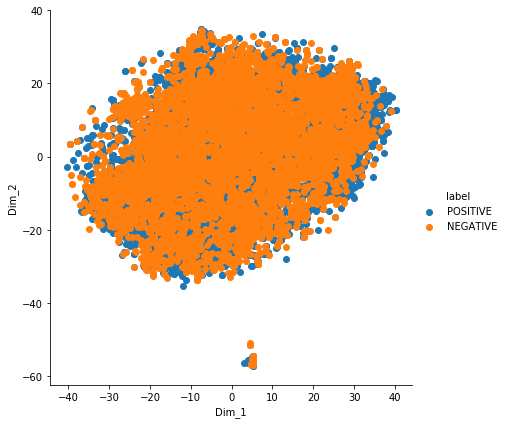

Total time taken:  82.50689482688904


In [78]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 10 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=50.0)

tsne_data = model.fit_transform(standard_w2v_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, w2v_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


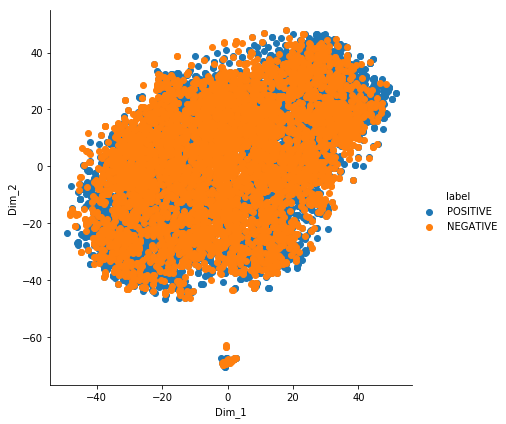

Total time taken:  68.35233402252197


In [79]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 30 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=30.0)

tsne_data = model.fit_transform(standard_w2v_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, w2v_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


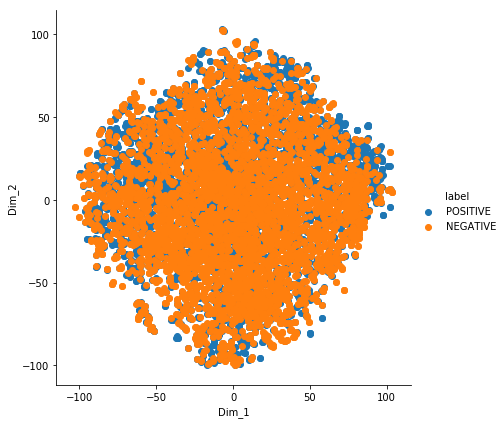

Total time taken:  52.10465860366821


In [80]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 5 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=5.0)

tsne_data = model.fit_transform(standard_w2v_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, w2v_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

### 3.2 TF-IDF weighted W2V

In [2]:
# Getting the cleaned data (taking 5k positive and negative data so that memory error should not occur)
preprossed_data = pd.read_pickle("all_cleaned_review.pkl")
preprossed_data_positive = preprossed_data[preprossed_data['ReviewType'] == 'POSITIVE'].head(5000)
preprossed_data_negative = preprossed_data[preprossed_data['ReviewType'] == 'NEGATIVE'].head(5000)
preprossed_data = pd.concat([preprossed_data_positive, preprossed_data_negative])
preprossed_data.shape

(10000, 11)

In [3]:
# Getting all the reviews/sentences for my featured data (Amazon fine food reviews)
all_sentences = [sentence.split() for sentence in preprossed_data['Text']]
print(len(all_sentences))
print(all_sentences[0])

10000
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'India', 'drooping', 'roses:', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'STILL', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


In [4]:
# Applying tfidf veotrizer model
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprossed_data['Text'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
len(dictionary)

25611

In [8]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names()

tfidf_sent_vectors = []
row=0;
for sent in tqdm(all_sentences): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            get_val = dictionary.get(word, 'None')
            if get_val != 'None':
                tf_idf = get_val*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.06it/s]


In [9]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)

### 3.2.1 Applying TSNE

In [10]:
# Standardize the data
standard_w2v_data = StandardScaler().fit_transform(tfidf_sent_vectors)
standard_w2v_data.shape

(10000, 50)

In [11]:
w2v_label = preprossed_data['ReviewType']
len(w2v_label)

10000

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


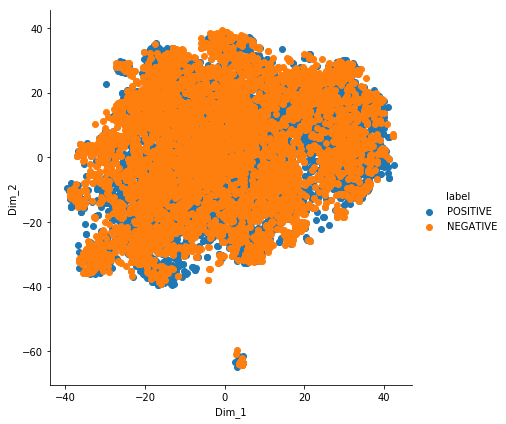

Total time taken:  144.4110381603241


In [12]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 10 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=50.0)

tsne_data = model.fit_transform(standard_w2v_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, w2v_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


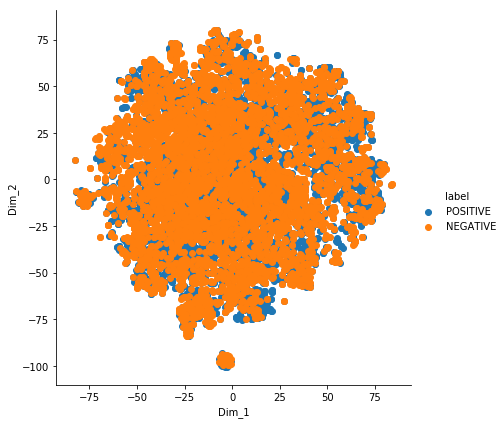

Total time taken:  94.95783019065857


In [13]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 10 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=10.0)

tsne_data = model.fit_transform(standard_w2v_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, w2v_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

C:\Users\soura\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


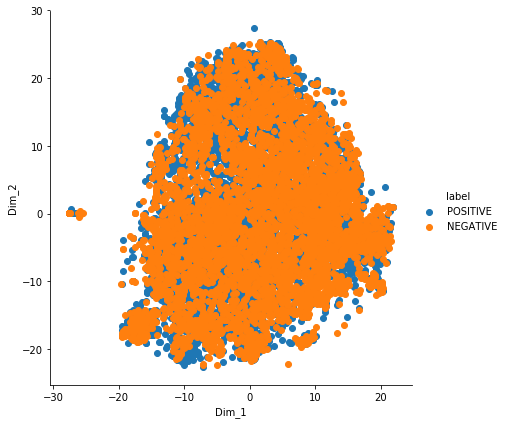

Total time taken:  175.99001455307007


In [14]:
# Applying t-SNE algorithm and plotting data for 5000 iteration and 100 perplexity
start = time.time()
model = mTSNE(n_jobs=4, n_components=2, random_state=0, n_iter=5000, perplexity=100.0)

tsne_data = model.fit_transform(standard_w2v_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, w2v_label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print("Total time taken: ",time.time()-start)

## 4. Word Cloud

In [15]:
# Concept taken from: https://medium.com/@cyanamous/amazon-fine-food-dataset-eda-text-featurization-data-visualization-892a40e1c312
from wordcloud import WordCloud, STOPWORDS

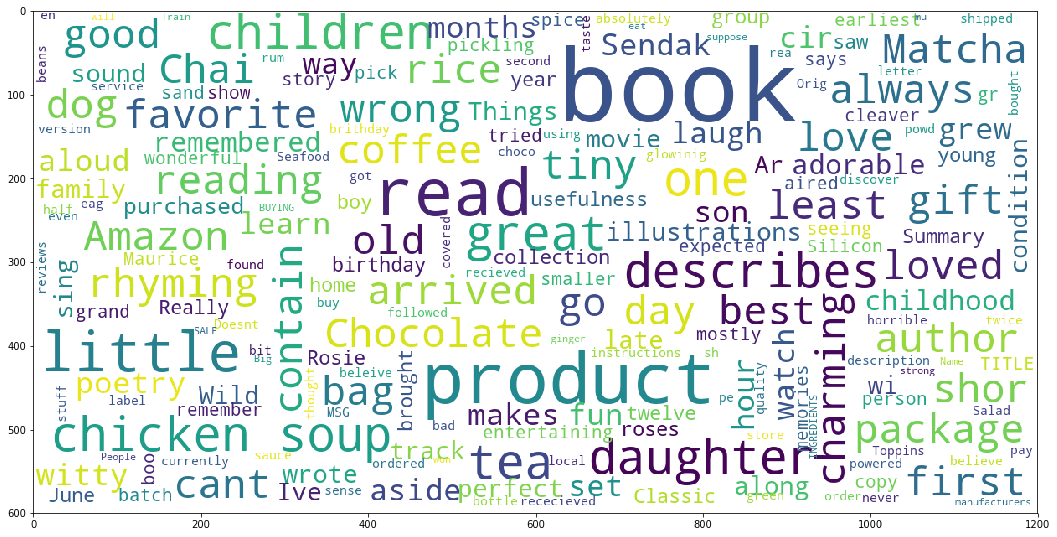

In [18]:
# Wordcolud for all the data set
plt.figure(figsize=(18,13))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(preprossed_data['Text']))
plt.imshow(wordcloud)
plt.show()

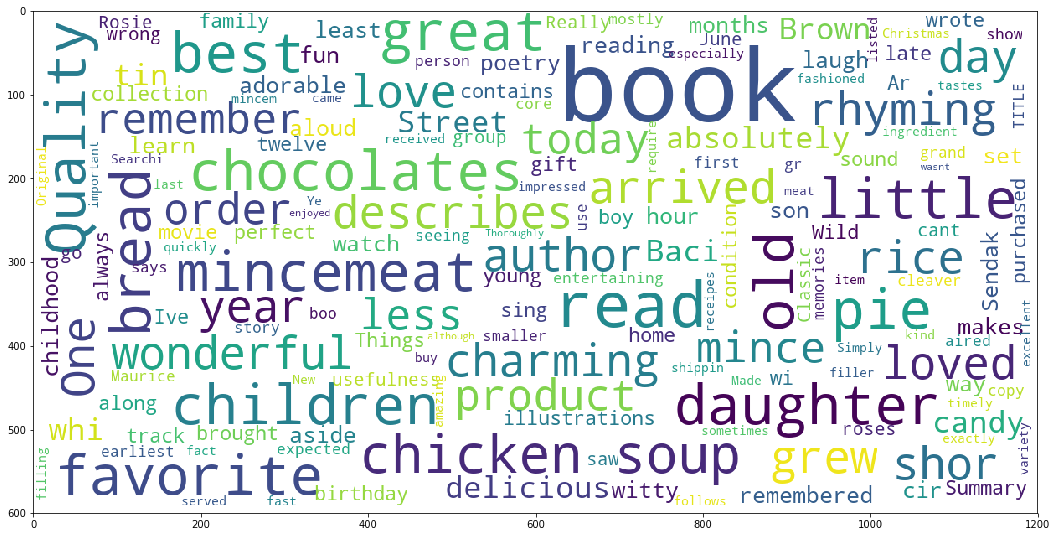

In [19]:
# Wordcolud for all the positive data set
preprossed_data_positive = preprossed_data[preprossed_data['ReviewType'] == 'POSITIVE']
plt.figure(figsize=(18,13))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(preprossed_data_positive['Text']))
plt.imshow(wordcloud)
plt.show()

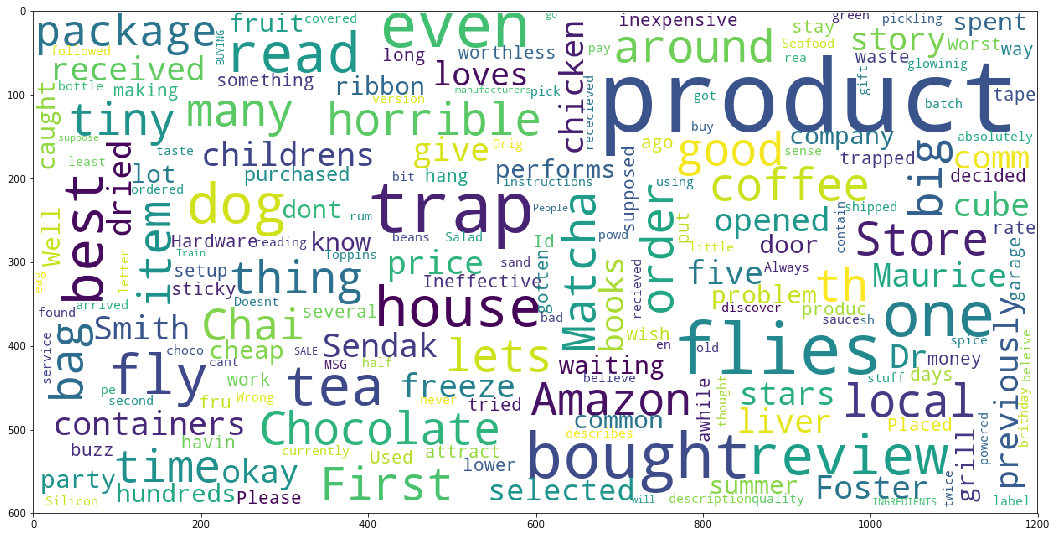

In [21]:
# Wordcolud for all the negative data set
preprossed_data_negative = preprossed_data[preprossed_data['ReviewType'] == 'NEGATIVE']
plt.figure(figsize=(18,13))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(preprossed_data_negative['Text']))
plt.imshow(wordcloud)
plt.show()